In [1]:
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

# OMNI data fitting

Several decades of solar wind and geospace environment data in ASCII format are described in

    http://spdf.gsfc.nasa.gov/pub/data/omni/00readme.txt

The "low resolution" (LRO) data

    ftp://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2.text

are available at a 1-hour cadence.  There are some data from the 1960's and 1970's, but mostly after 1980.  These records are convenient for quick looks and rough comparisons.

The "high resolution" (HRO) data start in 1981 and

    ftp://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/00readme.txt

are available at 1-minute and 5-minute cadence.  These data are useful for detailed analysis but with millions of records it can take a while to select subsets or calculate statistics.

In [2]:
# /home/bjackel/Dropbox/work/dataflow/magnet/nasa_omni.py
#dat = load_datafile('/data/public/spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_min2014.asc', dataname='HRO_1minute')
#np.save('/tmp/omni_1min_2014.npy', np.ma.getdata( dat ) )

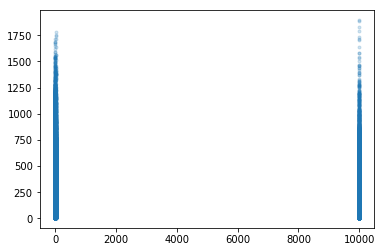

In [3]:
data = np.load('omni_1min_2014.npy')
plt.plot( data['bz'], data['ae_index'], '.', alpha=0.2 )

## Record format
There should be one of these records for each minute.  However, some or all of the fields may be missing and filled with a gap value eg. 9999.9

dat.dtype
Out[24]: dtype([('year', '<i4'), ('day', '<i4'), ('hour', '<i4'), ('minute', '<i4'), ('imf_id', '<i4'), ('plasma_id', '<i4'), ('imf_n_average', '<i4'), ('plasma_n_average', '<i4'), ('percent_interpolated', '<i4'), ('timeshift', '<i4'), ('timeshift_rms', '<i4'), ('pfn_rms', '<f4'), ('observation_time_delta', '<i4'), ('b_magnitude', '<f4'), ('bx', '<f4'), ('by', '<f4'), ('bz', '<f4'), ('by_gsm', '<f4'), ('bz_gsm', '<f4'), ('b_magnitude_rms', '<f4'), ('b_vector_rms', '<f4'), ('v', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('proton_density', '<f4'), ('temperature', '<f4'), ('dynamic_pressure', '<f4'), ('electric_field', '<f4'), ('plasma_beta', '<f4'), ('alfven_mach_number', '<f4'), ('pos_x', '<f4'), ('pos_y', '<f4'), ('pos_z', '<f4'), ('bow_x', '<f4'), ('bow_y', '<f4'), ('bow_z', '<f4'), ('ae_index', '<i4'), ('al_index', '<i4'), ('au_index', '<i4'), ('symd_index', '<i4'), ('symh_index', '<i4'), ('asymd_index', '<i4'), ('asymh_index', '<i4'), ('pc_index', '<f4'), ('magnetosonic_mach_number', '<f4'), ('utime', '<i4')])

(-19, 19)

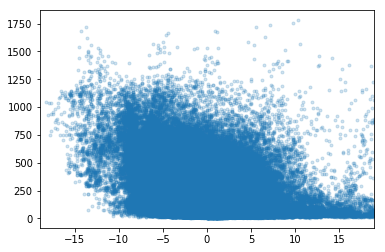

In [4]:
wgood = ( data['bz'] >= -29) & ( data['bz'] <= +19)
wgood &= (data['ae_index'] >= 0) & (data['ae_index']<= 1999 )
dat = data[wgood]
plt.plot( dat['bz'], dat['ae_index'], '.', alpha=0.2 )
plt.xlim(-19, 19)

In [5]:
dat = data[wgood]
scipy.stats.linregress( dat['bz'], dat['ae_index'])

LinregressResult(slope=-18.455171019220803, intercept=157.05261242837435, rvalue=-0.38685351368291365, pvalue=0.0, stderr=0.06507165316212786)

Use tools in scipy.optimize (or elsewhere) to fit a linear model with a single variable 

 $$ AE = c_1 B_z $$

by finding the value of $c_1$ which minimizes the goodness of fit given by 

 $$ \chi^2 = \sum (\mathrm{model} - \mathrm{data})^2 $$

then try two variables

 $$ AE = c_1 B_z + c_2 v_x $$
 
then try a non-linear transformation of a single variable
 
 $$ AE = c_1 B_z + c_2 v_x^2 $$ 
 
then try cross terms 

 $$ AE = c_1 B_z + c_2 v_x + c_3 B_z v_x $$ 
 
then explore combinations and transformations of variables to obtain "the best" model.  Think about what that means.

## Ridge and lasso regression
https://codingstartups.com/practical-machine-learning-ridge-regression-vs-lasso/

## reduction and standardization

In [6]:
data = np.load('omni_1min_2014.npy')

# Standardize variables to reduce numerical instability
dtype = np.dtype([ ('min', np.double), ('max', np.double), ('mean', np.double), ('stdev', np.double)])

process = {}
process['bz'] = np.array([(-29, +29, np.nan, np.nan)], dtype=dtype) 
process['by'] = np.array([(-29, +29, np.nan, np.nan)], dtype=dtype) 
process['vx'] = np.array([(-2100, +50.0, np.nan, np.nan)], dtype=dtype) 
process['ae_index'] = np.array([(-100, +2999, np.nan, np.nan)], dtype=dtype) 

In [7]:
allgood = np.ones( len(data), dtype=np.bool )

for name in process:
    p = process[name]
    wgood = (data[name] >= p['min']) & (data[name] <= p['max'])
    allgood = allgood & wgood   
    
newdat = {}
for name in process:
    p = process[name]
    dat = data[name][allgood].astype(np.double)

    if np.isnan( p['mean'] ):
        p['mean'] = np.mean( dat )
        p['stdev'] = np.std( dat )
        dat = ( dat - p['mean'] ) / p['stdev']
    
    newdat[name] = dat


In [8]:
# we want to fit 'ae_index' using one or more of the other quantities
#
if 'ae_index' in newdat:
    yfit = newdat.pop('ae_index')
    xfit = newdat.copy()

print( 'xfit: ', xfit, '\n yfit:', yfit)

xfit:  {'bz': array([-0.80434824, -0.86335371, -0.96450597, ...,  0.57244584,
        0.58368496,  0.55558715]), 'by': array([ 0.9060636 ,  0.83799952,  0.78636469, ..., -0.2205144 ,
       -0.31439591, -0.46460633]), 'vx': array([ 0.12260981,  0.12260981,  0.12642883, ..., -1.720783  ,
       -1.67622585, -1.74115245])} 
 yfit: [-0.84191476 -0.81800034 -0.80604313 ... -0.7522357  -0.7522357
 -0.74625709]


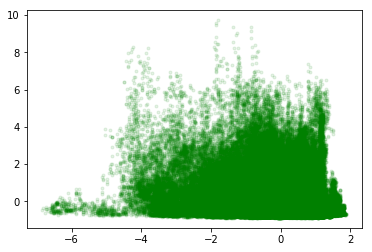

In [9]:
plt.plot( xfit['vx'], yfit, 'g.', alpha=0.1)

In [10]:
def fitfunc(param, *args):
    """ optimizers call this function to determine best-fit parameters
       
       args contains
       y: array of values to be fit
       x: dict of arrays of values for model
    """
    
    # unpack arguments and calculate figure-of-merit
    y, x, model = args
    return chi2( y, newdat, model, param )

def chi2(y, x, model, param):
    """ difference between model and observations,
        divided by # of points to give number of order 1
    """
    dy = y - model(param, x)
    return np.sum(dy**2) / len(y)

def model_bz(param, x):
    y = param[0] + x['bz'] * param[1]
    return y

def model_bz_vx(param, x):
    y = param[0] + x['bz'] * param[1] + param[2] * x['vx']
    return y

print( chi2( yfit, xfit, model_bz, (0, -1) ) )
print( chi2( yfit, xfit, model_bz, (0, 0) ) )
print( chi2( yfit, xfit, model_bz, (0, +1) ) )

1.246929568351635
1.0
2.753070431648365


Text(0.5,0,'p1')

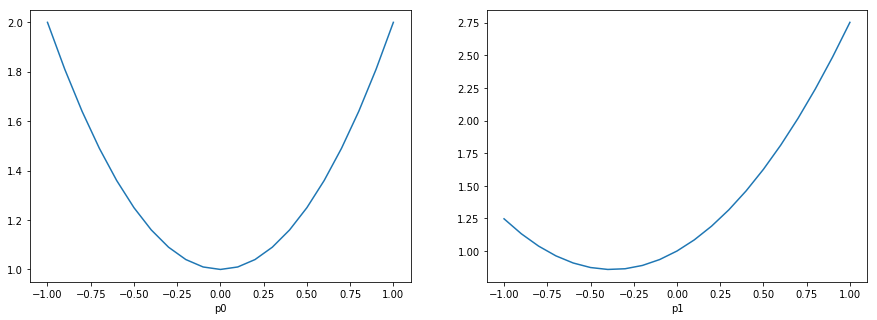

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15,5) )

plt.sca( axes[0] )
p0 = np.linspace(-1, +1, 21)
q0 = [chi2( yfit, xfit, model_bz, (_,0) ) for _ in p0]
plt.plot(p0, q0)
plt.xlabel('p0')

plt.sca( axes[1] )
p1 = np.linspace(-1, +1, 21)
q1 = [chi2( yfit, xfit, model_bz, (0,_) ) for _ in p1]
plt.plot(p1, q1)
plt.xlabel('p1')

0.8582212312442365 12 [ 1.98301301e-09 -3.76535224e-01]


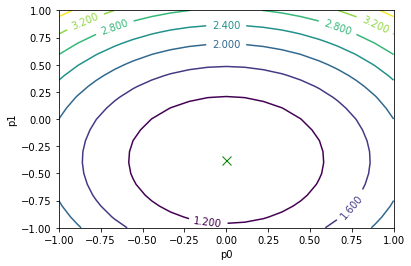

In [12]:
# show 2d surface of $\chi^2$
#
p0 = np.linspace(-1, +1, 19)
p1 = np.linspace(-1, +1, 21)
qq = np.zeros( [len(p0), len(p1)] )
for indx in range(len(p0)):
    for jndx in range(len(p1)):
        qq[indx,jndx] = chi2( yfit, xfit, model_bz, (p0[indx], p1[jndx]) ) 
               
cs = plt.contour(*np.meshgrid(p0, p1), qq.T ) 
plt.clabel(cs)
plt.xlabel('p0')
plt.ylabel('p1')
                
result = scipy.optimize.minimize(fitfunc, [0,1], (yfit, xfit, model_bz) )
print( result['fun'], result['nfev'], result['x'])
plt.plot( *result['x'], 'gx', ms=9)

In [13]:
# try a more complicated model and get a better fit
#
result = scipy.optimize.minimize(fitfunc, [1,0,1], (yfit, xfit, model_bz_vx) )
print( result['fun'], result['nfev'], result['x'])

0.8081292490948866 45 [ 6.55329622e-08 -3.87801436e-01 -2.24091945e-01]


In [14]:
# add more complexity, but fit doesn't improve
#

def model_silly(param, x):
    #print(len(param), param)
    y = param[0] + param[1]*x['bz'] + param[2]*x['vx'] 
    + param[3]*x['vx']*x['bz'] 
    + param[4]*x['vx']*x['vx'] + param[5]*x['bz']*x['bz']
    return y

result = scipy.optimize.minimize(fitfunc, np.ones(6), (yfit, xfit, model_silly), method=['Powell','Nelder-Mead'][0] )
print( result['fun'], result['nfev'], result['x'])

result = scipy.optimize.minimize(fitfunc, np.ones(6), (yfit, xfit, model_silly), method=['Powell','Nelder-Mead'][1] )
print( result['fun'], result['nfev'], result['x'])

0.808129249079834 277 [-9.94497175e-09 -3.87802138e-01 -2.24095796e-01  8.77034524e+00
  8.77034524e+00  8.77034524e+00]
0.8081292508602577 228 [-2.16081264e-05 -3.87783335e-01 -2.24063852e-01  1.42122252e+00
  2.38693007e+00  9.65807367e-01]


Text(0.5,0,'')

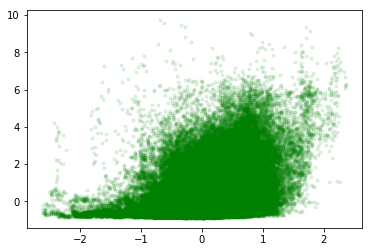

In [15]:
yy = model_silly( result['x'], xfit)
plt.plot(yy, yfit, 'g.', alpha=0.1)
plt.xlabel('')

In [16]:
def model_very_silly(param, x):
    #print(param)
    y = param[0] + param[1]*x['bz'] + param[2]*x['vx'] + param[3]*x['by']
    + param[4]*x['vx']*x['bz'] + param[5]*x['vx']*x['by'] + param[6]*x['by']*x['bz'] 
    + param[7]*x['vx']*x['vx'] + param[8]*x['bz']*x['bz'] + param[9]*x['by']*x['by'] 
    return y

In [17]:
result = scipy.optimize.minimize(fitfunc, np.ones(10), (yfit, xfit, model_very_silly), method=['Powell','Nelder-Mead'][1] )
print( result['fun'], result['nfev'], result['x'])

0.804342687452075 425 [ 1.63257180e-05 -3.84458834e-01 -2.27215083e-01  6.16908990e-02
  9.99136410e-01  1.53548823e+00  2.14182794e+00  1.53530935e+00
  1.40287574e+00  1.57721351e+00]


In [ ]:
def model_very_silly2(param, x):
    #print(param)
    y = param[0] + param[1]*x['bz'] + param[2]*x['vx'] + param[3]*x['by']
    + param[4]*x['vx']*x['bz'] + param[5]*x['vx']*x['by'] + param[6]*x['by']*x['bz'] 
    + param[7]*x['vx']*x['bz']*x['by'] 
    + param[8]*x['bz']*x['bz'] + param[9]*x['by']*x['by'] + param[10]*x['vx']*x['vx'] 
    return y
result = scipy.optimize.minimize(fitfunc, np.ones(11), (yfit, xfit, model_very_silly2), method=['Powell','Nelder-Mead'][1] )
print( result['fun'], result['nfev'], result['x'])

## Conclusion

The model which is linear in Bx gives a reduced chi-squared value of roughly 0.85; adding a linear vx term reduces chi2 to slightly above 0.8.

However, adding quadratic and cross terms does not appear to significantly improve the fit.

Note that the Powell fitter behaves strangely for larger numbers of parameters, while the Nelder-Mead fitter appears to be more stable.